# ovr_games.csv configuration

In [8]:
import requests
import pandas as pd
import csv
import json
from langdetect import detect
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity

# # The following code was used to build the OVR Games CSV that is later used as the dataset for modelling

# # # # # # # # # # # # # # # # # # # # # # # DO NOT UNCOMMENT # # # # # # # # # # # # # # # # # # # # # # #
# # Read IMDB Video Game CSV into a DataFrame
# df = pd.read_csv("imdb_video_game_rating.csv")

# # Remove the 'unnamed' index and 'directors' column
# df = df.drop(df.columns[0], axis=1).drop(df.columns[6], axis=1)

# # Add a 'tags' column to the DataFrame
# df['tags'] = ""

# # Convert the 'genre' column to lowercase
# df['genre'] = df['genre'].str.lower()

# # Get only English tags for a game_title
# def get_english_tags(game_title):
    
#     # Endpoint to get game details
#     get_game_details = f"https://api.rawg.io/api/games?search={game_title}&key={RAW_G_API_KEY}"

#     # Store the game details response as JSON
#     try:
#         response = requests.get(get_game_details)
#         if response is not None:
#             response_json = response.json()
#             results = response_json['results']
#             if results:
#                 tags = results[0].get('tags', [])
#                 english_tags = []
#                 if tags is not None:
#                     for tag in tags:
#                         tag_name = tag['name']
#                         if tag_name[0].isalpha() and tag_name[0].isascii():
#                             english_tags.append(tag_name.lower())
#                 return english_tags
#     except (KeyError, JSONDecodeError):
#         return []  # Return an empty list when KeyError or JSONDecodeError occurs
#     return []

    
# # Loop through the 'IMDB Video Game DataFrame' and add tags for each game
# for index, row in df.iterrows():
#     game_title = row['title']
#     english_tags = get_english_tags(game_title)
#     print(english_tags)
#     df.at[index, 'tags'] = english_tags
# # # # # # # # # # # # # # # # # # # # # # # DO NOT UNCOMMENT # # # # # # # # # # # # # # # # # # # # # # #



# Store the CSV in a DataFrame for model preparation  
df = pd.read_csv('ovr_games.csv')

# Display the CSV built using both the IMDB list of games and the RAWG API
list(df.columns)
df.head()


,title,year,genre,rating,votes,plot,tags
0,The Last of Us: Part I,2022,"action, adventure, drama",9.8,601,Experience the emotional storytelling and unfo...,"['singleplayer', 'multiplayer', 'full controll..."
1,Red Dead Redemption II,2018,"action, adventure, crime",9.7,36441,Amidst the decline of the Wild West at the tur...,"['singleplayer', 'multiplayer', 'atmospheric',..."
2,The Witcher 3: Wild Hunt - Blood and Wine,2016,"action, adventure, drama",9.7,7610,Geralt is in the southern province of Toussain...,"['horror', 'war', 'blood', 'love']"
3,The Witcher 3: Wild Hunt,2015,"action, adventure, drama",9.7,26328,A monster hunter for hire embarks on an epic j...,"['singleplayer', 'full controller support', 'a..."
4,The Last of Us,2013,"action, adventure, drama",9.7,61103,"In a hostile, post-pandemic world, Joel and El...",['exclusive']


# Exploratory Data Analysis

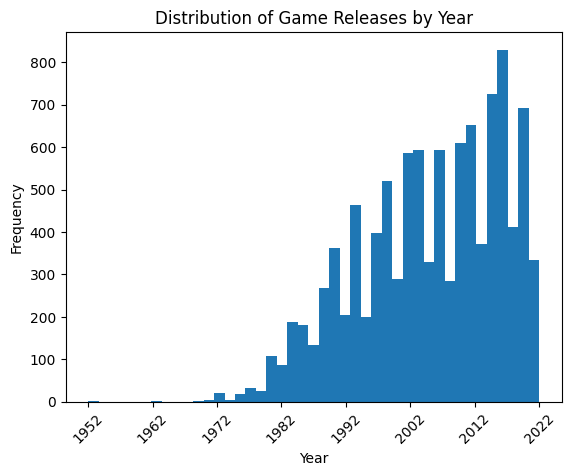

In [9]:
# Calculate the earliest and most recent years
earliest_year = df['year'].min()
most_recent_year = df['year'].max()

# Create the histogram
plt.hist(df['year'], bins='auto')

# Set the x-axis label
plt.xlabel('Year')

# Set the y-axis label
plt.ylabel('Frequency')

# Set the title of the histogram
plt.title('Distribution of Game Releases by Year')

# Set the x-axis tick labels
plt.xticks(range(earliest_year, most_recent_year+1, 10), rotation=45)

# Display the histogram
plt.show()


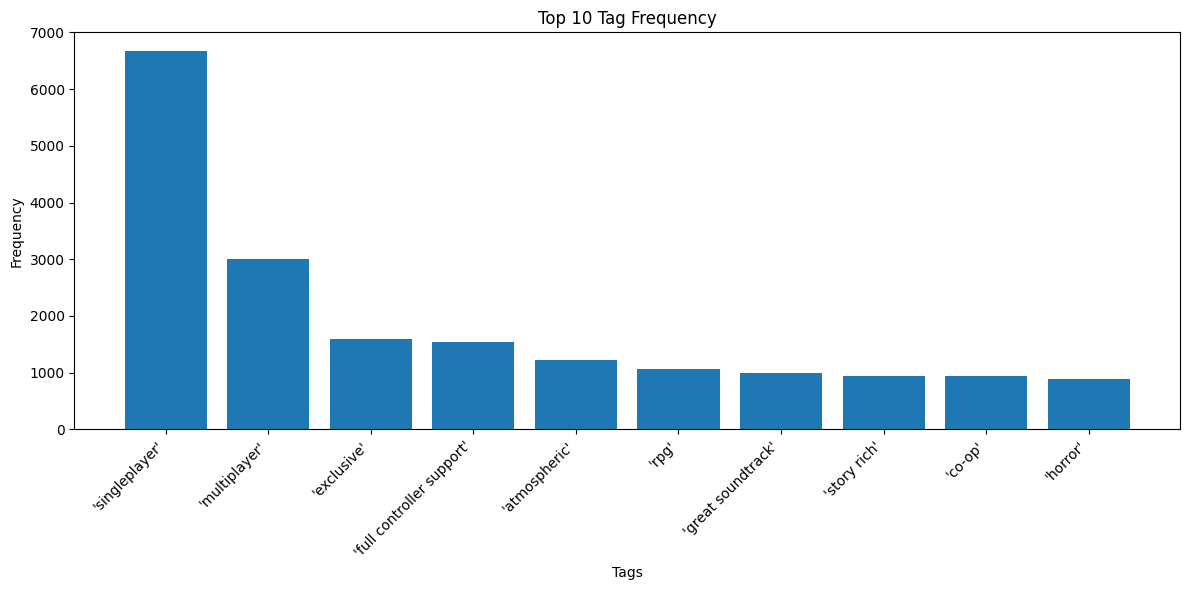

In [10]:
# Count the frequency of each tag
tag_counts = {}
for tags in df['tags']:
    for tag in tags.split(','):
        tag = tag.strip()  # Remove leading/trailing whitespace
        tag = tag.strip('[').strip(']')  # Remove brackets
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1

# Sort the tags based on their frequency
sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)

# Extract the top 10 tags and their frequencies
top_tags = sorted_tags[:10]
tags = [tag[0] for tag in top_tags]
frequencies = [tag[1] for tag in top_tags]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(tags, frequencies)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Top 10 Tag Frequency')
plt.xticks(rotation=45, ha='right')  # Tilt the tags and align them to the right
plt.tight_layout()
plt.show()


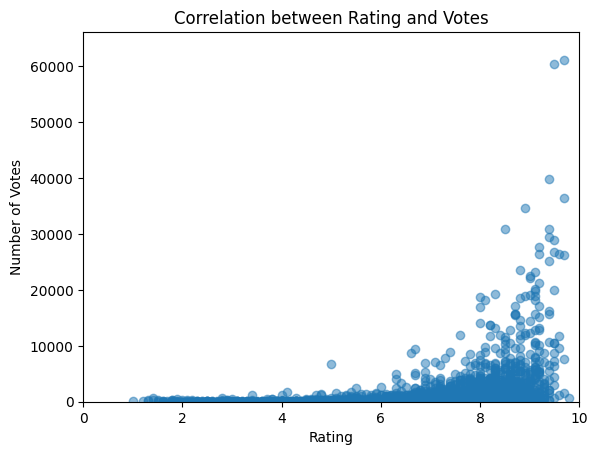

In [11]:
# Extract the 'votes' and 'rating' columns from your DataFrame
votes = df['votes']
rating = df['rating']

# Create a scatter plot
plt.scatter(rating, votes, alpha=0.5)

# Set the labels and title
plt.xlabel('Rating')
plt.ylabel('Number of Votes')
plt.title('Correlation between Rating and Votes')

# Adjust the x-axis and y-axis limits for visualization
plt.xlim(0, 10)
plt.ylim(0, max(votes) + 5000)

# Display the plot
plt.show()


# K-Means Algorithm and Vectorization to build the clustered_dataset.csv

In [12]:
# Preprocess the 'tags' column
tags = df['tags']
tags = tags.apply(lambda x: ' '.join(eval(x)))

# Preprocess the 'genre' column
df['genre'] = df['genre'].apply(lambda x: x.split(','))
df['genre'] = df['genre'].apply(lambda x: ' '.join(x))

# Normalize the 'votes' column
scaler = MinMaxScaler()
df['votes_normalized'] = scaler.fit_transform(df['votes'].values.reshape(-1, 1))

# Combine the preprocessed columns
df['features'] = tags + ' ' + df['genre'] + ' ' + df['votes_normalized'].astype(str) + ' ' + df['rating'].astype(str)

# Create the document-term matrix using TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', min_df=2)
doc_term_matrix = vectorizer.fit_transform(df['features'])

# Apply the K-means clustering algorithm
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(doc_term_matrix)

# Assign cluster labels to the original DataFrame
df['cluster_label'] = kmeans.labels_

# Save the clustered dataset as a CSV file
df.to_csv('clustered_dataset.csv', index=False)

# Displaying the added normalized votes, features, and cluster_label that was built using ML
list(df.columns)
df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,title,year,genre,rating,votes,plot,tags,votes_normalized,features,cluster_label
0,The Last of Us: Part I,2022,action adventure drama,9.8,601,Experience the emotional storytelling and unfo...,"['singleplayer', 'multiplayer', 'full controll...",0.009755,singleplayer multiplayer full controller suppo...,3
1,Red Dead Redemption II,2018,action adventure crime,9.7,36441,Amidst the decline of the Wild West at the tur...,"['singleplayer', 'multiplayer', 'atmospheric',...",0.596353,singleplayer multiplayer atmospheric great sou...,3
2,The Witcher 3: Wild Hunt - Blood and Wine,2016,action adventure drama,9.7,7610,Geralt is in the southern province of Toussain...,"['horror', 'war', 'blood', 'love']",0.124472,horror war blood love action adventure drama...,2
3,The Witcher 3: Wild Hunt,2015,action adventure drama,9.7,26328,A monster hunter for hire embarks on an epic j...,"['singleplayer', 'full controller support', 'a...",0.430832,singleplayer full controller support atmospher...,3
4,The Last of Us,2013,action adventure drama,9.7,61103,"In a hostile, post-pandemic world, Joel and El...",['exclusive'],1.000000,exclusive action adventure drama 0.999999999...,4


# Game Recommender Logic and UI Build

In [17]:
# Create the dictionary to map game titles to cluster labels
game_cluster_mapping = {}

for index, row in df.iterrows():
    game_title = row['title']
    cluster_label = row['cluster_label']
    
    # Add the game title and cluster label to the dictionary
    game_cluster_mapping[game_title] = cluster_label
    
# Create an empty dictionary to store game features mapping
game_features_mapping = {}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    game_title = row['title']
    tags = row['tags']
    
    # Split the tags string into a list of tags
    tag_list = tags.split(',')
    
    # Map the game title to its list of tags
    game_features_mapping[game_title] = tag_list

# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the game features
features_list = [' '.join(features) for features in game_features_mapping.values()]
vectorizer.fit(features_list)


# Function to handle the search button click event
def handle_search_button_click(button):
    search_term = search_bar.value
    if search_term:
        filtered_results = [title for title in game_titles if search_term.lower() in title.lower()]
        search_results.options = filtered_results
    else:
        search_results.options = []

        
# Function to handle adding selected games to the Your Games box
def handle_add_to_list(button):
    selected_games = search_results.value
    your_games.options = list(set(your_games.options + selected_games))
    

# Function to handle getting recommendations
def handle_recommendations_button_click(button):
    selected_games = your_games.options
    if selected_games:
        # Get cluster labels for selected games
        selected_clusters = [game_cluster_mapping[game] for game in selected_games]
        
        # Find games from the same clusters
        similar_games = []
        for game, cluster in game_cluster_mapping.items():
            if cluster in selected_clusters and game not in selected_games:
                similar_games.append(game)
        
        # Convert game features to TF-IDF representation
        selected_features_tfidf = vectorizer.transform([' '.join(game_features_mapping[game]) for game in selected_games])
        similar_features_tfidf = vectorizer.transform([' '.join(game_features_mapping[game]) for game in similar_games])
        
        # Calculate cosine similarity between selected games and similar games
        similarity_scores = cosine_similarity(selected_features_tfidf, similar_features_tfidf)
        
        # Sort similar games based on cosine similarity scores
        similar_games_sorted = [game for _, game in sorted(zip(similarity_scores[0], similar_games), reverse=True)]
        
        # Display the recommendations
        with recommendations_output:
            recommendations_output.clear_output()
            print('Recommendations:')
            for game in similar_games_sorted[:10]:  # Display top 10 recommendations
                print(game)
    else:
        with recommendations_output:
            recommendations_output.clear_output()


# # # # # # # # # # # # # # # UI LAYOUT # # # # # # # # # # # # # # #
# Load the clustered dataset
df = pd.read_csv('clustered_dataset.csv')

# Create a list of unique game titles
game_titles = df['title'].unique().tolist()

# Sort game titles alphabetically
game_titles.sort()

# Create a text box widget for searching game titles
search_bar = widgets.Text(
    placeholder='Search game titles',
    description='Search:'
)

# Create a button widget for initiating the search
search_button = widgets.Button(description='Search')

# Create a list box widget for displaying the search results
search_results = widgets.SelectMultiple(
    options=[],
    description='Results:',
    layout=widgets.Layout(height='150px')
)

# Create a list box widget for displaying the selected games
your_games = widgets.SelectMultiple(
    options=[],
    description='Your Games:',
    layout=widgets.Layout(height='150px')
)
            
# Register the function as the event handler for the search button click event
search_button.on_click(handle_search_button_click)

# Create a button for adding selected games to Your Games
add_button = widgets.Button(description='Add to Your Games')
add_button.on_click(handle_add_to_list)

# Create a button for getting recommendations
recommendations_button = widgets.Button(description='Get Recommendations', layout=widgets.Layout(width='200px'))
recommendations_button.on_click(handle_recommendations_button_click)

# Create an output widget for displaying the recommendations
recommendations_output = widgets.Output()

# Adjust the spacing between the widgets
search_bar.layout.margin = '5 5px 0 0'
search_button.layout.margin = '5 5px 0 0'
add_button.layout.margin = '5 5px 0 0'

# Arrange the search bar and button horizontally
search_box = widgets.HBox([search_bar, search_button])

# Arrange the search results and add button horizontally
search_results_box = widgets.VBox([search_results])
add_button_box = widgets.VBox([add_button], layout=widgets.Layout(align_items='flex-start'))
search_results_and_add_button = widgets.HBox([search_results_box, add_button_box])

# Arrange the search box, search results, and add button vertically
left_side_box = widgets.VBox([search_box, search_results_and_add_button])

# Arrange the Your Games box and recommendations button vertically
your_games_box = widgets.VBox([your_games, recommendations_button])

# Arrange the left side and Your Games box horizontally
main_box = widgets.HBox([left_side_box, your_games_box])

# Display the widgets
display(main_box)
display(recommendations_output)


Output()